### Importing the dependencies

In [35]:
import numpy as np 
import pandas as pd 
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as display
import time
import copy
from PIL import Image
import io
import timm

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn

import tensorflow as tf
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
train_files = glob.glob('../input/tpu-getting-started/*/train/*.tfrec')
val_files = glob.glob('../input/tpu-getting-started/*/val/*.tfrec')
test_files = glob.glob('../input/tpu-getting-started/*/test/*.tfrec')

In [3]:
train_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, train_feature_description)

train_ids = []
train_class = []
train_images = []

for i in train_files:
  train_image_dataset = tf.data.TFRecordDataset(i)

  train_image_dataset = train_image_dataset.map(_parse_image_function)

  ids = [str(id_features['id'].numpy())[2:-1] for id_features in train_image_dataset] # [2:-1] is done to remove b' from 1st and 'from last in train id names
  train_ids = train_ids + ids

  classes = [int(class_features['class'].numpy()) for class_features in train_image_dataset]
  train_class = train_class + classes

  images = [image_features['image'].numpy() for image_features in train_image_dataset]
  train_images = train_images + images

In [4]:
val_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, val_feature_description)

val_ids = []
val_class = []
val_images = []

for i in val_files:
    val_image_dataset = tf.data.TFRecordDataset(i)

    val_image_dataset = val_image_dataset.map(_parse_image_function)

    ids = [str(image_features['id'].numpy())[2:-1] for image_features in val_image_dataset]
    val_ids += ids

    classes = [int(image_features['class'].numpy()) for image_features in val_image_dataset]
    val_class += classes 

    images = [image_features['image'].numpy() for image_features in val_image_dataset]
    val_images += images

In [5]:
test_feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_test(example_proto):
    return tf.io.parse_single_example(example_proto, test_feature_description)

test_ids = []
test_images = []
for i in test_files:
    test_image_dataset = tf.data.TFRecordDataset(i)
    
    test_image_dataset = test_image_dataset.map(_parse_image_function_test)

    ids = [str(id_features['id'].numpy())[2:-1] for id_features in test_image_dataset]
    test_ids = test_ids + ids

    images = [image_features['image'].numpy() for image_features in test_image_dataset]
    test_images = test_images + images

### "Looking at our data!"

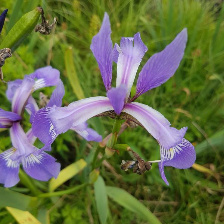

In [6]:
display.display(display.Image(data=train_images[1]))

### Our dataset

In [7]:
class MyDataset(Dataset):
    def __init__(self, ids, cls, imgs, transforms, is_test=False):
        self.ids = ids
        if not is_test:
            self.cls = cls
        self.imgs = imgs
        self.transforms = transforms
        self.is_test = is_test
    
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = Image.open(io.BytesIO(img))
        img = self.transforms(img)
        if self.is_test:
            return img, -1, self.ids[idx]
        return img, int(self.cls[idx]), self.ids[idx]

### Data augmentation and normalization


In [8]:
# train_transforms = transforms.Compose([
#                         transforms.RandomResizedCrop(224),
#                         transforms.RandomHorizontalFlip(),
#                         transforms.RandomVerticalFlip(),
#                         transforms.ToTensor(),
#                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                         transforms.RandomErasing()
#                     ])

# test_transforms = transforms.Compose([
#                         transforms.CenterCrop(224),
#                         transforms.Resize(224),
#                         transforms.ToTensor(),
#                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#                     ])
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_ds = MyDataset(train_ids, train_class, train_images, auto_transforms)
valid_ds = MyDataset(val_ids, val_class, val_images, auto_transforms)
test_ds = MyDataset(val_ids, [], test_images, auto_transforms, is_test = True)

In [10]:
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dataloader = DataLoader(valid_ds, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size = 32, shuffle = False)

In [11]:
print(f"Length of train dataloader: {len(train_dataloader)} batches of {32}")
image_id, label, image  = next(iter(train_dataloader))

Length of train dataloader: 1595 batches of 32


In [12]:
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {32}")
image_id, label, image  = next(iter(val_dataloader))

Length of validation dataloader: 464 batches of 32


In [13]:
dataset_sizes = {
    'train': len(train_ds),
    'val': len(valid_ds),
    'test': len(test_ds)
}

In [14]:
dataset_sizes

{'train': 51012, 'val': 14848, 'test': 14848}

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
model_effnet = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [26]:
for param in model_effnet.features.parameters():
    param.requires_grad = False

In [27]:
model_effnet.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=104, # same number of output units as our number of classes
                    bias=True)).to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")### Training loop

In [28]:
training_loss, validation_loss  = [], []
def train_model(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            if (phase == 'train'):
                training_loss.append(epoch_loss)
            elif (phase == 'val'):
                validation_loss.append(epoch_loss)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


   

In [29]:
def predict(model, loader):
    model = model.to(device)
    with torch.no_grad():
        torch.cuda.empty_cache()
        model.eval()
        preds = dict()
        for i, (inputs, _, ids) in enumerate(loader):
            inputs = inputs.to(device)
            output = model(inputs)
            _, pred = output.max(dim=1)
            for i, j in zip(ids, pred.cpu().detach()):
                preds[i] = j
            
        return preds

In [30]:
# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_effnet.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [31]:
train_model(model_effnet, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=10)

Epoch 0/9
----------
train Loss: 3.0624 Acc: 0.3736

val Loss: 2.2923 Acc: 0.5647

Epoch 1/9
----------
train Loss: 1.9747 Acc: 0.6002

val Loss: 1.6930 Acc: 0.6647

Epoch 2/9
----------
train Loss: 1.5693 Acc: 0.6772

val Loss: 1.4371 Acc: 0.7076

Epoch 3/9
----------
train Loss: 1.3417 Acc: 0.7149

val Loss: 1.2493 Acc: 0.7346

Epoch 4/9
----------
train Loss: 1.1957 Acc: 0.7394

val Loss: 1.1533 Acc: 0.7524

Epoch 5/9
----------
train Loss: 1.0960 Acc: 0.7568

val Loss: 1.0827 Acc: 0.7602

Epoch 6/9
----------
train Loss: 1.0156 Acc: 0.7726

val Loss: 1.0419 Acc: 0.7670

Epoch 7/9
----------
train Loss: 0.9756 Acc: 0.7826

val Loss: 1.0026 Acc: 0.7687

Epoch 8/9
----------
train Loss: 0.9663 Acc: 0.7840

val Loss: 1.0117 Acc: 0.7738

Epoch 9/9
----------
train Loss: 0.9635 Acc: 0.7834

val Loss: 1.0180 Acc: 0.7699

Training complete in 70m 17s
Best val Acc: 0.7738


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

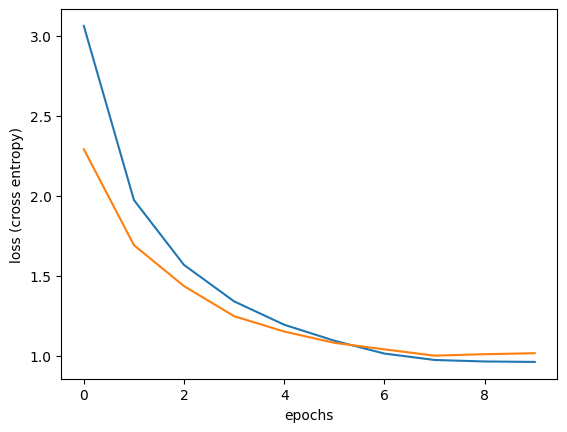

In [36]:
plt.plot(training_loss, label = "training loss")
plt.plot(validation_loss, label = "validation loss")
plt.xlabel("epochs")
plt.ylabel("loss (cross entropy)")
plt.show()

In [37]:
preds = predict(model_effnet, test_dataloader)

In [38]:
pred_df = pd.DataFrame(list(preds.items()), columns=['id', 'class'])
def tensor_to_int(tensor):
    return int(tensor.item())

pred_df['class'] = pred_df['class'].apply(lambda x: tensor_to_int(x))
pred_df.head()

,id,class
0,34dfc29ae,75
1,83c7db008,4
2,1eccb53ac,90
3,d76c017b1,53
4,d63a88e8f,82


In [39]:
pred_df.to_csv('flowerclass.csv', index = False)